In [170]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation,TimeDistributed
from tensorflow.keras.models import Sequential
import math
from statistics import stdev
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [171]:
#Open the dataset 
dataset = pd.read_csv('Desktop/GOOGL.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [172]:
#Examine data
dataset.shape

(4431, 7)

In [173]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [174]:
dataset.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [175]:
#Check if data missing
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [176]:
#Change type of date to datetime type 
dataset.Date=pd.to_datetime(dataset['Date'])

In [177]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [178]:
#Analyse date data
dataset.Date.min(),dataset.Date.max()
dataset.Date.max()-dataset.Date.min()

Timedelta('6426 days 00:00:00')

In [179]:
#Create column for date to use in graph
dataset.set_index('Date',inplace=True)
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...
2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800


In [180]:
#Start test for stationary data
#Strat by splitting data into chunks
np.round(dataset.shape[0]/10,0)

443.0

In [181]:
#Statistics for each chunks to find if large deviation in 
#mean or variance -- data is probably not stationary
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(dataset['High'].iloc[(i*443):(i*443)+443].mean())
    std.append(stdev(dataset['High'].iloc[(i*443):(i*443)+443]))

In [182]:
#Chart of mean and std
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,140.365196,51.153975
1,253.262980,46.102784
2,220.912289,43.122744
3,277.775461,24.652126
4,338.114265,47.663683
5,537.664131,54.208791
6,710.515983,88.280105
7,1021.089795,126.361815
8,1229.109186,124.523716
9,2263.732568,524.220412


In [183]:
#Since clearly different in each chunk
#Assume non stationary

#Need more test
#Augmented Dickey-Fuller test
#H0: non stationary
#H1: stationary

result = adfuller(dataset['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.414008
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [184]:
#P-values > 0.05 and ADF higher then any critical point
#No reason to reject H0 so data is non stationary
#This give us info that it will take a long time to train model

In [185]:
#Choose data wanted to predict
new_dataset=dataset['High'].iloc[:-4]

#Split dataset to train 80% and test 20%
train_len = math.ceil(len(new_dataset)*0.8)
train_len

3542

In [209]:
#Choose 15 because fit better after test
step=15
train_data = new_dataset[0:train_len]

X_train=[]
Y_train=[]

for i in range(step, len(train_data)):
    X_train.append(train_data[i-step:i])
    Y_train.append(train_data[i])
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [210]:
#Reshaping train data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3527, 15, 1)

In [211]:
X_train

array([[[  52.082081],
        [  54.594597],
        [  56.796799],
        ...,
        [  51.051052],
        [  51.566566],
        [  51.406406]],

       [[  54.594597],
        [  56.796799],
        [  55.855858],
        ...,
        [  51.566566],
        [  51.406406],
        [  53.333332]],

       [[  56.796799],
        [  55.855858],
        [  54.054054],
        ...,
        [  51.406406],
        [  53.333332],
        [  54.259258]],

       ...,

       [[1226.949951],
        [1225.910034],
        [1232.76001 ],
        ...,
        [1214.869995],
        [1198.98999 ],
        [1188.550049]],

       [[1225.910034],
        [1232.76001 ],
        [1226.530029],
        ...,
        [1198.98999 ],
        [1188.550049],
        [1186.660034]],

       [[1232.76001 ],
        [1226.530029],
        [1235.170044],
        ...,
        [1188.550049],
        [1186.660034],
        [1190.939941]]])

In [212]:
#Model LSTM with layers
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
opt1= tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

#Compile LSTM
model.compile(loss='mean_squared_error', optimizer=opt1)
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 15, 50)            10400     
                                                                 
 lstm_40 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 100)               5100      
                                                                 
 dense_31 (Dense)            (None, 25)                2525      
                                                                 
 dense_32 (Dense)            (None, 1)                 26        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In [213]:
#Split test data
test_data = new_dataset[train_len-step:]

X_test=[]
Y_test=[] 

for i in range(step, len(test_data)):
    X_test.append(test_data[i-step:i])
    Y_test.append(test_data[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [214]:
#Reshaping data test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [215]:
#Prediction
prediction = model.predict(X_test)

28/28 [==============================] - 1s 6ms/step


In [216]:
#Chart of prediction and real value
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2018-09-13,1187.859985,1189.155762
2018-09-14,1188.000000,1185.983521
2018-09-17,1181.819946,1186.877441
2018-09-18,1181.329956,1179.066528
2018-09-19,1176.270020,1180.248169
...,...,...
2022-03-14,2608.179932,2676.269043
2022-03-15,2597.090088,2588.396240
2022-03-16,2666.659912,2594.753906


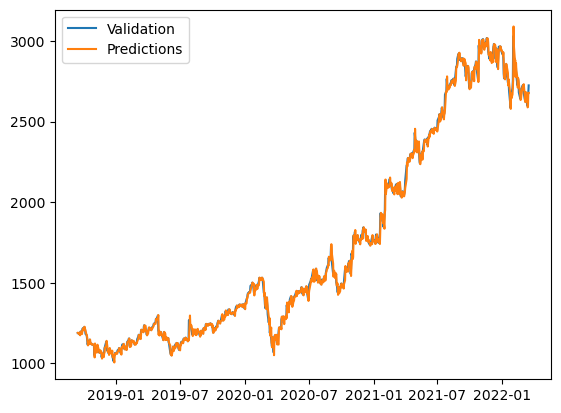

In [217]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

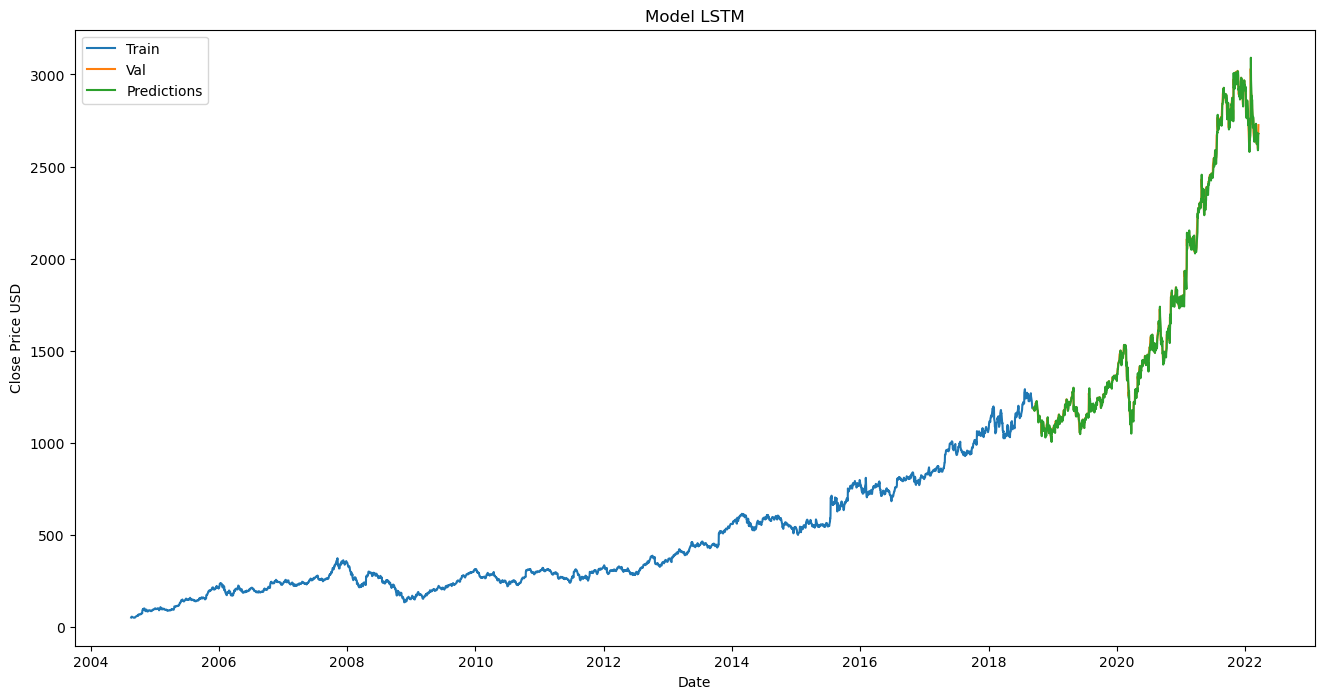

In [218]:
train = new_dataset[:train_len]
valid = pd.DataFrame(new_dataset[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

In [219]:
#Metric error
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_test)
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_test, lstm_valid_pred)))


28/28 [==============================] - 0s 8ms/step
Train RMSE: 7.454235157112955
Validation RMSE: 30.43787273444679
